In [1]:
!pip install tqdm pyLDAvis gensim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from quickstart import get_data
service, messages = get_data()

In [8]:
print(len(messages))

500


In [7]:
import base64
import re
from tqdm import tqdm
import pandas as pd

def parse_email_digest(content):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    # print(text.encode('utf=8'))
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    return articles

data = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date).date()

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    
    # Extract article information for all articles featured in daily digest
    for article in parse_email_digest(content):
        data.append([date, *article])


100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


In [9]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('article_data_via_gmail_api.csv', index=False)
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-10,How To Plot Time Series,Produce elegant plots that tell a story,Nadim Kawwa,Towards Data Science,5
1,2021-08-10,Scraping Data from a Website,Using pandas to scrap data in a single line of...,Himanshu Sharma,MLearning.ai,2
2,2021-08-10,"How to Web Scrape Tables Online, Using Python ...",Showing you how to create a universal code tha...,Christopher Zita,Analytics Vidhya,7
3,2021-08-10,Stop Using Exceptions Like This in Python,Four common error-handling mistakes to avoid i...,Jerry Ng,Better Programming,5
4,2021-08-10,Plotly Charts are Making Python Smarter,As data science has become a larger and larger...,Jake from Mito,trymito,3
...,...,...,...,...,...,...
1693,2021-03-23,"Actually, Not a Ton of People Are Moving to Fl...",It turns out it's mostly tech moguls who have ...,Marker Editors,Marker,2
1694,2021-03-23,Why We Should All Care About the Messy Busines...,Marker readers weigh in on the relevance of st...,Marker Editors,Marker,2
1695,2021-03-23,Why the Pandemic Is Causing You Motivation Par...,It's time to reset your brain by being nice to it,Allison Hirschlag,The Bold Italic,5
1696,2021-03-23,The Key to Achieving Your Goals Is Controlled ...,3 strategies for making mistakes you can learn...,Kristin Wong,Forge,5


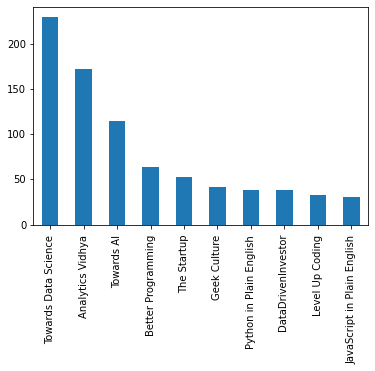

In [10]:
df['Publication'].value_counts().iloc[:10].plot.bar();

## Data Preprocessing

### Lemmatization and Stemming

In [11]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [18]:
doc_sample = df['Title'].iloc[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\ntokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['How', 'To', 'Plot', 'Time', 'Series']

tokenized and lemmatized document: 
['plot', 'time', 'seri']


In [19]:
df['Titles_combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df[['Title', 'Subtitle', 'Titles_combined']].head()

,Title,Subtitle,Titles_combined
0,How To Plot Time Series,Produce elegant plots that tell a story,How To Plot Time Series Produce elegant plots ...
1,Scraping Data from a Website,Using pandas to scrap data in a single line of...,Scraping Data from a Website Using pandas to s...
2,"How to Web Scrape Tables Online, Using Python ...",Showing you how to create a universal code tha...,"How to Web Scrape Tables Online, Using Python ..."
3,Stop Using Exceptions Like This in Python,Four common error-handling mistakes to avoid i...,Stop Using Exceptions Like This in Python Four...
4,Plotly Charts are Making Python Smarter,As data science has become a larger and larger...,Plotly Charts are Making Python Smarter As dat...


In [20]:
# processed_docs = df['Titles_combined'].map(preprocess)
processed_docs = df['Title'].map(preprocess)
processed_docs[:10]

0                                   [plot, time, seri]
1                                [scrap, data, websit]
2         [scrape, tabl, onlin, python, beautifulsoup]
3                         [stop, except, like, python]
4                 [plot, chart, make, python, smarter]
5    [perform, exploratori, data, analysi, line, code]
6                                          [cod, trap]
7                            [need, break, rule, data]
8    [python, selenium, lifetim, suppli, garlic, pi...
9                       [machin, learn, model, deploy]
Name: Title, dtype: object

### Bag of Words

In [21]:
dictionary = gensim.corpora.Dictionary(processed_docs)
for k, v in list(dictionary.items())[:10]:
    print(k, v)

0 plot
1 seri
2 time
3 data
4 scrap
5 websit
6 beautifulsoup
7 onlin
8 python
9 scrape


In [22]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_doc_1 = bow_corpus[0]

for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                                     dictionary[bow_doc_1[i][0]], 
                                                     bow_doc_1[i][1]))


Word 0 ("plot") appears 1 time.
Word 1 ("time") appears 1 time.


### TF-IDF

In [23]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
print(corpus_tfidf[0])

[(0, 0.6771504535941453), (1, 0.7358445917428784)]


### Latent Dirichlet Allocation (LDA)

In [24]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)

In [25]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.188*"data" + 0.173*"scienc" + 0.114*"scientist" + 0.064*"word" + 0.051*"product" + 0.046*"intellig" + 0.040*"python" + 0.022*"book" + 0.014*"machin" + 0.014*"beginn"
Topic: 1 Word: 0.105*"build" + 0.094*"write" + 0.083*"understand" + 0.079*"year" + 0.079*"featur" + 0.069*"want" + 0.057*"network" + 0.049*"import" + 0.036*"extract" + 0.022*"notebook"
Topic: 2 Word: 0.133*"languag" + 0.110*"natur" + 0.108*"process" + 0.084*"use" + 0.034*"python" + 0.033*"librari" + 0.030*"data" + 0.029*"text" + 0.026*"beginn" + 0.025*"scientist"
Topic: 3 Word: 0.114*"know" + 0.087*"person" + 0.078*"dataset" + 0.076*"effect" + 0.066*"introduct" + 0.065*"python" + 0.044*"plot" + 0.041*"data" + 0.032*"scienc" + 0.027*"creat"
Topic: 4 Word: 0.185*"learn" + 0.170*"machin" + 0.146*"data" + 0.087*"visual" + 0.026*"deep" + 0.026*"scienc" + 0.022*"predict" + 0.020*"build" + 0.019*"algorithm" + 0.018*"understand"
Topic: 5 Word: 0.091*"text" + 0.086*"model" + 0.084*"algorithm" + 0.070*"python" + 0.0

In [26]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.004740 -0.136435       1        1  8.266304
0     -0.097133 -0.069046       2        1  8.230385
10    -0.045795 -0.046812       3        1  8.209844
12    -0.036004  0.046602       4        1  7.646221
6     -0.136478  0.094583       5        1  7.553040
4     -0.019853 -0.095536       6        1  6.895943
11     0.011958 -0.005869       7        1  6.755498
1      0.263313 -0.035087       8        1  6.630336
8      0.002128  0.265466       9        1  6.344214
2     -0.036077  0.026792      10        1  6.247823
13     0.146156  0.040709      11        1  6.041209
3      0.030858  0.055615      12        1  6.005744
14    -0.100906 -0.077298      13        1  5.551440
7     -0.014660  0.003692      14        1  5.073153
9      0.037231 -0.067376      15        1  4.548847, topic_info=        Term        Freq       Total Category  logprob  loglift
5     python  124.000000  124.000000  Default  30.0000  30.0000
66  mathemat   24.000000   24.000000  Default  29.0000  29.0000
10     learn   71.000000   71.000000  Default  28.0000  28.0000
3      scrap   29.000000   29.000000  Default  27.0000  27.0000
7       code   29.000000   29.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
28   process    0.684848   21.868756  Topic15  -4.8245  -0.3733
2       data    1.590473  106.685316  Topic15  -3.9819  -1.1156
12     model    0.783263   35.263396  Topic15  -4.6903  -0.7168
0       plot    0.642805   27.941100  Topic15  -4.8879  -0.6817
3      scrap    0.640708   29.056229  Topic15  -4.8912  -0.7241

[557 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
14        1  0.586746  algorithm
14        3  0.090269  algorithm
14        6  0.090269  algorithm
14        8  0.045134  algorithm
14       11  0.045134  algorithm
...     ...       ...        ...
33        8  0.645189      write
33       12  0.107532      write
33       15  0.053766      write
34        5  0.143437       year
34        8  0.717184       year

[529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 11, 13, 7, 5, 12, 2, 9, 3, 14, 4, 15, 8, 10])

### BERTopic

In [47]:
!pip install bertopic --upgrade
!pip uninstall huggingface-hub -y
!pip install huggingface-hub==0.0.8

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached bertopic-0.9.0-py2.py3-none-any.whl (55 kB)
  Using cached numpy-1.21.1-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
  Using cached plotly-4.14.2-py2.py3-none-any.whl (13.2 MB)
  Using cached hdbscan-0.8.27.tar.gz (6.4 MB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /Users/sejaldua/opt/anaconda3/bin/python /Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/pip install --ignore-installed --no-user --prefix /private/var/folders/n2/m7q730ss09d_cds_rgg93lsh0000gn/T/pip-build-env-wcvzwik5/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel cython numpy
       cwd: None
  Complete output (31 lines):
  Traceback (most recent call last):
    File "/Users/sejaldua/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/sejaldua/opt/anaconda3/lib/python3.8/runpy.py", li

  Using cached bertopic-0.4.1-py2.py3-none-any.whl (20 kB)
  Using cached bertopic-0.4.0-py2.py3-none-any.whl (20 kB)
Found existing installation: huggingface-hub 0.0.12
Uninstalling huggingface-hub-0.0.12:
  Successfully uninstalled huggingface-hub-0.0.12
  Using cached huggingface_hub-0.0.8-py3-none-any.whl (34 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.8.1 requires huggingface-hub==0.0.12, but you have huggingface-hub 0.0.8 which is incompatible.


In [48]:
from bertopic import BERTopic

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/huggingface_hub-0.0.8-py3.8.egg'